### Description of Data Dimensions

- Lat
- Lon
- Time (year, month, day)
- Variable
- Ensemble Member
- Model

### Set up Workspace

In [1]:
%matplotlib inline

import xarray as xr
import intake
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


### Choose Settings for what to load into dictionary

In [2]:
this_experiment_id = ['historical','ssp126']#, 'ssp245', 'ssp370', 'ssp585']
this_variable_id = 'tas'
this_table_id = 'Amon'
this_grid_label='gn'

### Load Data into Data Dictionary

In [3]:
import CreateDataDict
[dataset_info, dset_dict, modelnames]=CreateDataDict.createDataDict(this_experiment_id, this_variable_id, this_table_id, this_grid_label)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 28 group(s)


### Create Pandas Dataset

Structure: rows = models; columns = scenarios; data = timeseries

In [28]:
def CreateDataFrame1(dataset_info,modelnames, this_experiment_id,this_table_id,this_grid_label):
    df = pd.DataFrame(index=modelnames) 
    for expname in this_experiment_id:
        experiment_id=expname
        expvals = [None] * len(modelnames)
        df[expname]=expvals
        if expname=='historical':
            activity_id='CMIP'
        else:
            activity_id='ScenarioMIP'
        for modelname in modelnames:
            source_id = modelname
            dataset_info_subset = dataset_info[dataset_info['source_id']==source_id]
            institution_id = list(set(dataset_info_subset['institution_id']))[0]
            nametag = activity_id+'.'+institution_id+'.'+source_id+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
            if nametag in dset_dict:
                if nametag=='CMIP.UA.MCM-UA-1-0.historical.Amon.gn':
                    thisdata=dset_dict[nametag][this_variable_id].mean(dim=['latitude','longitude'])
                else:
                    thisdata=dset_dict[nametag][this_variable_id].mean(dim=['lat','lon'])
            else:
                thisdata='No data'
            df[expname][modelname]=thisdata
    return df
df = CreateDataFrame1(dataset_info,modelnames, this_experiment_id,this_table_id,this_grid_label)

### WANT TO MAKE A MULTIMODEL DATA STRUCTURE WITH DIMENSIONS OF: MODELNAME, TIME, SCENARIO

Beyond this point, this is me trying to experiment with different data structures, etc. Doesn't really work/make sense

In [30]:
modelnames_to_test_time_type = ['NESM3', 'BCC-CSM2-MR', 'NorCPM1', 'UKESM1-0-LL', 'GISS-E2-1-G-CC', 'SAM0-UNICON', 'CanESM5', 'MCM-UA-1-0', 'GISS-E2-1-G', 'MIROC6', 'MRI-ESM2-0', 'BCC-ESM1', 'MIROC-ES2L', 'CESM2-WACCM', 'CESM2', 'CAMS-CSM1-0', 'GISS-E2-1-H', 'HadGEM3-GC31-LL']
for modelname in modelnames_to_test_time_type:
    print(df['historical'][modelname]['time'].attrs['calendar'])
    print(df['historical'][modelname]['time'].attrs['units'])

gregorian
hours since 1850-01-16 12:00:00.000000
365_day
days since 1850-01-01
noleap
days since 0001-01-01
360_day
days since 1850-01-16 00:00:00.000000
noleap
hours since 1850-01-16 12:00:00.000000
noleap
hours since 1850-01-16 12:00:00.000000
365_day
days since 1850-01-01
noleap
days since 0001-01-01
noleap
hours since 1850-01-16 12:00:00.000000
proleptic_gregorian
hours since 1850-01-16 12:00:00
proleptic_gregorian
days since 1850-01-01
365_day
days since 1850-01-01
gregorian
hours since 1850-01-16 12:00:00.000000
noleap
days since 0001-01-01
noleap
hours since 1850-01-15 12:00:00.000000
365_day
days since 1850-01-01
noleap
hours since 1850-01-16 12:00:00.000000
360_day
days since 1850-01-16 00:00:00.000000


In [24]:
nametag='CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn'
thisdata=dset_dict[nametag]
thistime = thisdata['time']
thisdata = thisdata.mean(dim=['member_id'])
thisval=thisdata.mean(dim=['lat','lon'])['tas']

ds = xr.Dataset({'CESM2': thisval},\
                coords={'time': thistime})
                        #'modelnames': modelnameInd, \
                        #'lat': thislat, \
                        #'lon': thislon, \
#ds['ssp585']=xr.DataArray(fakedata2, coords=[modelnameInd, thistime], dims=['modelnames', 'time'])

In [25]:
experiment_id='historical'
activity_id='CMIP'
for modelname in modelnames:
    source_id = modelname
    dataset_info_subset = dataset_info[dataset_info['source_id']==source_id]
    institution_id = list(set(dataset_info_subset['institution_id']))[0]
    nametag = activity_id+'.'+institution_id+'.'+source_id+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
    if nametag in dset_dict:
        print(nametag)
        thisdata=dset_dict[nametag]
        thistime = thisdata['time']
        thisdata = thisdata.mean(dim=['member_id'])
        if nametag=='CMIP.UA.MCM-UA-1-0.historical.Amon.gn':
            thisval=thisdata.mean(dim=['latitude','longitude'])['tas']
        else:
            thisval=thisdata.mean(dim=['lat','lon'])['tas']
    ds[modelname]=thisval

CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.NCAR.CESM2-WACCM.historical.Amon.gn
CMIP.BCC.BCC-ESM1.historical.Amon.gn
CMIP.NCC.NorCPM1.historical.Amon.gn
CMIP.UA.MCM-UA-1-0.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn
CMIP.SNU.SAM0-UNICON.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn
CMIP.NCAR.CESM2.historical.Amon.gn
CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.MOHC.HadGEM3-GC31-LL.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
CMIP.NUIST.NESM3.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.MIROC.MIROC-ES2L.historical.Amon.gn


CAMS-CSM1-0
CESM2-WACCM
BCC-ESM1
NorCPM1
MCM-UA-1-0
GISS-E2-1-G
SAM0-UNICON


KeyboardInterrupt: 

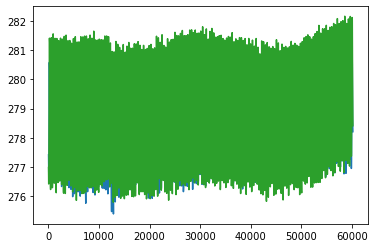

In [26]:
for modelname in modelnames:
    print(modelname)
    yvals = ds[modelname].values
    plt.plot(xvals,yvals)